# Tracking Pipeline

### Load Training Data

In [4]:
"""
1. load data
"""


import glob


# Read in our vehicles and non-vehicles
non_vehicles_gti = glob.glob('training_data/non-vehicles/GTI/*.png')
non_vehicles_extras = glob.glob('training_data/non-vehicles/Extras/*.png')
vehicles_gti_far = glob.glob('training_data/vehicles/GTI_Far/*.png')
vehicles_gti_left = glob.glob('training_data/vehicles/GTI_Left/*.png')
vehicles_gti_mid = glob.glob('training_data/vehicles/GTI_MiddleClose/*.png')
vehicles_gti_right = glob.glob('training_data/vehicles/GTI_Right/*.png')
vehicles_kitti = glob.glob('training_data/vehicles/KITTI_extracted/*.png')

cars = []
notcars = []

for image in non_vehicles_gti:
    notcars.append(image)
for image in non_vehicles_extras:
    notcars.append(image)
for image in vehicles_gti_far:
    cars.append(image)
for image in vehicles_gti_left:
    cars.append(image)
for image in vehicles_gti_mid:
    cars.append(image)
for image in vehicles_gti_right:
    cars.append(image)
for image in vehicles_kitti:
    cars.append(image)

print('Number of vehicles:', len(cars))
print('Number of non vehicles:', len(notcars))

Number of vehicles: 8792
Number of non vehicles: 8968


### Data examples

Vehicle Image Shape: (64, 64, 3)
Non Vehicle Image Shape: (64, 64, 3)


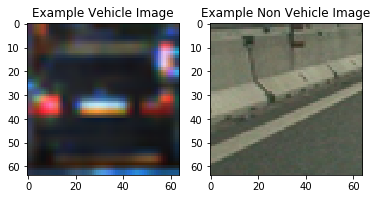

In [23]:
"""
2. data example
"""

import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# randomly choose an example
example_car = random.choice(cars)
example_notcar = random.choice(notcars)

# read iamge
car_image = mpimg.imread(example_car)
notcar_iamge = mpimg.imread(example_notcar)

# image shape
print('Vehicle Image Shape:', str(car_image.shape))
print('Non Vehicle Image Shape:', str(notcar_iamge.shape))
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Vehicle Image')
plt.subplot(122)
plt.imshow(notcar_iamge)
plt.title('Example Non Vehicle Image')
plt.show()

### Histogram of Oriented Gradients

In [5]:
"""
3. get HOG features function
"""
from skimage.feature import hog


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features

In [ ]:
"""
4. extract HOG features function
"""
import cv2


def extract_hog_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file, cv2.IMREAD_COLOR)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: 
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

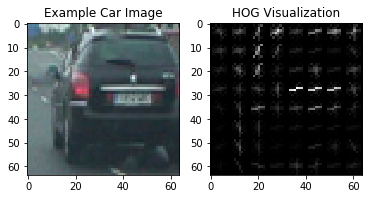

In [40]:
"""
5. extract HOG features from the training images
"""
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2


# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

## choose HOG parameters

In [33]:
"""
6. choose HOG parameters
"""

import time
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

for colorspace in ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']:
    for hog_channel in [0, 1, 2, 'ALL']:
        # colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        orient = 9
        pix_per_cell = 8
        cell_per_block = 2
        # hog_channel = 0 # Can be 0, 1, 2, or "ALL"

        t=time.time()
        car_features = extract_hog_features(cars, cspace=colorspace, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)
        notcar_features = extract_hog_features(notcars, cspace=colorspace, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to extract HOG features...')
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)

        print('Using:',orient,'orientations',pix_per_cell,
              'pixels per cell and', cell_per_block,
              'cells per block',colorspace,'colorspace',
              hog_channel,'hog_channel')
        print('Feature vector length:', len(X_train[0]))
        # Use a linear SVC 
        svc = LinearSVC()
        # Check the training time for the SVC
        t=time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
        print('For these',n_predict, 'labels: ', y_test[0:n_predict])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

18.61 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block RGB colorspace 0 hog_channel
Feature vector length: 1764
8.12 Seconds to train SVC...
Test Accuracy of SVC =  0.944
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  0.  0.  1.  0.]
0.002 Seconds to predict 10 labels with SVC
18.66 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block RGB colorspace 1 hog_channel
Feature vector length: 1764
6.77 Seconds to train SVC...
Test Accuracy of SVC =  0.9493
My SVC predicts:  [ 0.  0.  1.  1.  0.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  0.  0.  0.  1.  1.]
0.00193 Seconds to predict 10 labels with SVC
18.05 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block RGB colorspace 2 hog_channel
Feature vector length: 1764
6.71 Seconds to train SVC...
Test Accuracy of SVC =  0.9496
My 

In [6]:
"""
7. color features
"""


import numpy as np


# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [ ]:
"""
8. extract color features function
"""


import cv2


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_color_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file, cv2.IMREAD_COLOR)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: 
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

## choose color parameters

In [47]:
"""
9. choose color parameters
"""

import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


parameters = [8, 16, 32, 64]
for spatial in parameters:
    for histbin in parameters:
        car_features = extract_color_features(cars, cspace='YCrCb', spatial_size=(spatial, spatial),
                                hist_bins=histbin, hist_range=(0, 256))
        notcar_features = extract_color_features(notcars, cspace='YCrCb', spatial_size=(spatial, spatial),
                                hist_bins=histbin, hist_range=(0, 256))

        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)

        print('Using spatial binning of:',spatial,
            'and', histbin,'histogram bins')
        print('Feature vector length:', len(X_train[0]))
        # Use a linear SVC 
        svc = LinearSVC()
        # Check the training time for the SVC
        t=time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
        print('For these',n_predict, 'labels: ', y_test[0:n_predict])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 4 and 4 histogram bins
Feature vector length: 60
1.43 Seconds to train SVC...
Test Accuracy of SVC =  0.9099
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  0.  0.  0.  1.]
0.00128 Seconds to predict 10 labels with SVC
Using spatial binning of: 4 and 8 histogram bins
Feature vector length: 72
1.66 Seconds to train SVC...
Test Accuracy of SVC =  0.9268
My SVC predicts:  [ 1.  1.  1.  1.  1.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  0.  1.  1.  0.  1.]
0.00113 Seconds to predict 10 labels with SVC
Using spatial binning of: 4 and 16 histogram bins
Feature vector length: 96
1.92 Seconds to train SVC...
Test Accuracy of SVC =  0.9479
My SVC predicts:  [ 0.  0.  1.  1.  0.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]
0.00124 Seconds to predict 10 labels with SVC
Using spatial binning of: 4 and 32 histogram bins
Feature vector length: 144
2.49 Se

## Combined

In [4]:
"""
10. Combine all features
"""



import numpy as np
import cv2

def augmenting_images(img,angle,scale):
    (w, h) = img.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    augmented = cv2.warpAffine(img, M, (w, h))
    return augmented

def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        img = cv2.imread(file, cv2.IMREAD_COLOR)
        images=[]
        images.append(img)
                # Augment image
        images.append(cv2.flip(img, 1))
        # apply color conversion if other than 'RGB'
        for image in images:
            if cspace != 'RGB':
                if cspace == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                elif cspace == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
                elif cspace == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
                elif cspace == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
                elif cspace == 'YCrCb':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
            else: 
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

In [5]:
"""
11. train a classifier
"""


import time
import numpy as np
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


# parameters
colorspace = 'YCrCb'
hog_channel = 'ALL'

orient = 16
pix_per_cell = 8
cell_per_block = 2

spatial = 16
histbin = 64

car_features = extract_features(cars, cspace=colorspace, spatial_size=(spatial, spatial),
                                      hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                                      pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                      hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, spatial_size=(spatial, spatial),
                                         hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                         hog_channel=hog_channel)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = SVC()
# parameters
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10]} 
# grid search
clf = GridSearchCV(svc, parameters, n_jobs=12)
# Check the training time for the SVC
t=time.time()
# svc.fit(X_train, y_train)
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# best parameters
print('best parameters:', clf.best_params_)
# Check the score of the SVC
# print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
# t=time.time()
# n_predict = 10
# print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
# print('For these',n_predict, 'labels: ', y_test[0:n_predict])
# t2 = time.time()
# print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 16 and 64 histogram bins
Feature vector length: 10368
8672.02 Seconds to train SVC...
best parameters: {'C': 10, 'kernel': 'rbf'}
Test Accuracy of SVC =  0.9966


In [6]:
"""
12. Save Model
"""
from sklearn.externals import joblib


joblib.dump(clf, 'model1.pkl')
joblib.dump(X_scaler, 'X_scaler1.pkl')

['X_scaler1.pkl']

### Sliding Window Search

In [3]:
"""
13. Load Model
"""
from sklearn.externals import joblib


clf = joblib.load('model1.pkl')
X_scaler = joblib.load('X_scaler1.pkl')

In [2]:
"""
14. slide window function
"""

import numpy as np


# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):    

    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else: 
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Compute spatial features
    spatial_features = bin_spatial(feature_image, size=spatial_size)

    # Compute histogram features

    hist_features = color_hist(feature_image, nbins=hist_bins)

    # Compute HOG features

    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)


    # Return concatenated array of features
    return np.concatenate((spatial_features, hist_features, hog_features))


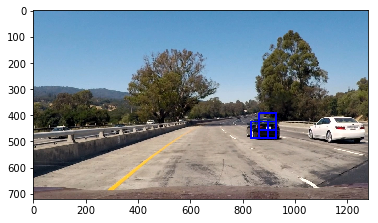

In [47]:
"""
15. test on iamge
"""


import matplotlib.pyplot as plt
import numpy as np
import cv2


color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 32  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (8, 8) # Spatial binning dimensions
hist_bins = 64   # Number of histogram bins
y_start_stop = [360, None] # Min and max in y to search in slide_window()


image = cv2.imread('test_images/test3.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)                       

window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=6)                    

window_img = cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB)

plt.imshow(window_img)
plt.show()

In [68]:
"""
16. improved scale process
"""


import cv2
import numpy as np


def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
#     img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,0),6) 
                
    return draw_img

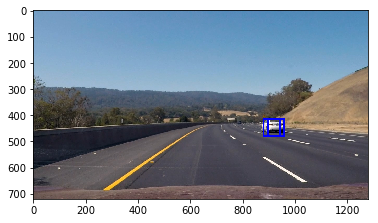

In [15]:
"""
17. test on image
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt


ystart = 400
ystop = 656
scale = 1
orient = 16
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (16, 16)
hist_bins = 64

image = cv2.imread('test_images/test5.jpg')

out_img = find_cars(image, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
plt.imshow(out_img)
plt.show()

In [ ]:
"""
18. test on image
"""


ystart = 400
ystop = 656
scale = 1
orient = 16
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (16, 16)
hist_bins = 64


images = glob.glob('test_images/test*.jpg')

for idx, fname in enumerate(images):
    image = cv2.imread(fname)

    out_img = find_cars(image, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    cv2.imwrite('output_images/{idx}.jpg'.format(idx=idx), out_img)

In [7]:
"""
19. add heatmap
"""


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [36]:
"""
20. find cars with heat
"""


import cv2
import numpy as np


def find_cars_heat(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)

    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.array(np.concatenate((spatial_features, hist_features, hog_features))).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,0),6) 
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    return draw_img, heatmap

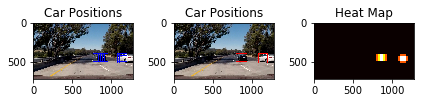

In [33]:
"""
21. test on image
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label


ystart = 400
ystop = 656
scale = 1.5
orient = 32
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (8, 8)
hist_bins = 64

image = cv2.imread('test_images/test5.jpg')

out_img, heatmap = find_cars_heat(image, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)

labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

fig = plt.figure()
plt.subplot(131)
plt.imshow(out_img)
plt.title('Car Positions')
plt.subplot(132)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(133)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

In [63]:
"""
22. define a class to improve video output
"""

class HeatMap():
    def __init__(self):
        self.heat = None
        self.n_iteration = 12
        self.recent_heat = []
        self.detected = False
        self.fliter = 0.4
        self.threshold = 1
        self.best_heat = None
        
    def add_heat(self, bbox_list):
        for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            self.heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    def update(self):
#         self.heat = np.zeros_like(self.heat).astype(np.float)
#         for box in bbox_list:
#         # Add += 1 for all pixels inside each bbox
#         # Assuming each "box" takes the form ((x1, y1), (x2, y2))
#             self.heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        self.heat[self.heat <= self.threshold] = -1
        self.heat[self.heat > self.threshold] = 1

        if len(self.recent_heat) < self.n_iteration:
            self.recent_heat.append(self.heat)
        else:
            self.recent_heat.append(self.heat)
            self.recent_heat.pop(0)
        
        if len(self.recent_heat) > 1:
            self.best_heat = np.average(self.recent_heat, axis=0)
        else:
            self.best_heat = self.heat
        
        self.best_heat[self.best_heat <= self.fliter] = 0
        self.best_heat[self.best_heat > self.fliter] = 1
        
        self.detected = False

In [64]:
"""
23. draw function
"""


def draw_labeled_bboxes_video(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if abs(bbox[0][0]-bbox[1][0]) > 64 and abs(bbox[0][1]-bbox[1][1]) > 64:
            cv2.putText(img, 'Vehicle', (bbox[0][0],bbox[0][1]-20), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,0),2,cv2.LINE_AA)
            cv2.rectangle(img, bbox[0], bbox[1], (255,255,0), 6)
    # Return the image
    return img

In [65]:
"""
24. find car function
"""
import cv2
import numpy as np


def find_cars_heat_video(img, heatmap, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
#     draw_img = np.copy(img)
    
    if not heatmap.detected:
        heatmap.heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heatmap.detected = True

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YCrCb)
    for scale in scales:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        box_list = []

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.array(np.concatenate((spatial_features, hist_features, hog_features))).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    box_list.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
    #                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,0),6) 
        # Add heat to each box in box list
        heatmap.add_heat(box_list)
    heatmap.update()
    return np.clip(heatmap.best_heat, 0, 255)

In [66]:
"""
25. process video function
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label


def process_video(image):

    ystart = 400
    ystop = 656
    scales = [1, 1.5]
    orient = 16
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    spatial_size = (16, 16)
    hist_bins = 64
    
    global heatmaps

    heatmap = find_cars_heat_video(image, heatmaps, ystart, ystop, scales, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    labels = label(heatmap)
    draw_img = draw_labeled_bboxes_video(np.copy(image), labels)
    
    return draw_img


In [67]:
"""
26. process video
"""

import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

heatmaps = HeatMap()

project_output = 'test_output3.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_output3.mp4
[MoviePy] Writing video test_output3.mp4


 97%|█████████▋| 38/39 [35:01<00:58, 58.43s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output3.mp4 

CPU times: user 34min 59s, sys: 3.38 s, total: 35min 2s
Wall time: 35min 2s
